In [1]:
!pip install pyspark

# Importing Libraries

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count, year, explode, split


# EDA

In [4]:
# Initialize Spark Session
spark = SparkSession.builder.appName("Netflix EDA").getOrCreate()

# Load dataset
netflix_df = spark.read.csv("/content/netflix_titles.csv", header=True, inferSchema=True)

# Print schema and show first few rows
netflix_df.printSchema()
netflix_df.show(5)
print("Row Count:", netflix_df.count())


root
 |-- show_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = true)
 |-- description: string (nullable = true)

+-------+-------+--------------------+---------------+--------------------+-------------+------------------+------------+------+---------+--------------------+--------------------+
|show_id|   type|               title|       director|                cast|      country|        date_added|release_year|rating| duration|           listed_in|         description|
+-------+-------+--------------------+---------------+--------------------+-------------+------------------+------------+------+---------+-------------------

In [5]:
# Count null values in each column
from pyspark.sql.functions import col, sum

null_counts = netflix_df.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in netflix_df.columns]
)
null_counts.show()


+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|show_id|type|title|director|cast|country|date_added|release_year|rating|duration|listed_in|description|
+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|      0|   1|    2|    2636| 826|    832|        13|           2|     6|       5|        3|          3|
+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+



In [6]:
# Describe statistics for numeric columns
netflix_df.describe().show()

# Distinct values in categorical columns
netflix_df.select("type").distinct().show()
netflix_df.select("rating").distinct().show()


+-------+--------------------+-------------+---------------------------------+--------------------+--------------------+----------------+---------------+-----------------+-----------------+-------------+--------------------+--------------------+
|summary|             show_id|         type|                            title|            director|                cast|         country|     date_added|     release_year|           rating|     duration|           listed_in|         description|
+-------+--------------------+-------------+---------------------------------+--------------------+--------------------+----------------+---------------+-----------------+-----------------+-------------+--------------------+--------------------+
|  count|                8809|         8808|                             8807|                6173|                7983|            7977|           8796|             8807|             8803|         8804|                8806|                8806|
|   mean|       

In [7]:
netflix_df.groupBy("type").agg(count("*").alias("count")).show()

+-------------+-----+
|         type|count|
+-------------+-----+
|         NULL|    1|
|      TV Show| 2676|
|        Movie| 6131|
|William Wyler|    1|
+-------------+-----+



In [8]:
# Extract release year from date_added
netflix_df = netflix_df.withColumn("year_added", year("date_added"))

# Group and count by year
netflix_df.groupBy("year_added").agg(count("*").alias("count")).orderBy("year_added").show()

+----------+-----+
|year_added|count|
+----------+-----+
|      NULL| 8809|
+----------+-----+



In [9]:
# Split genres (listed_in column) into individual genres
genres_df = netflix_df.withColumn("genre", explode(split("listed_in", ", ")))
genres_df.groupBy("genre").agg(count("*").alias("count")).orderBy("count", ascending=False).show()

# Analyze rating distribution
netflix_df.groupBy("rating").agg(count("*").alias("count")).orderBy("count", ascending=False).show()

+--------------------+-----+
|               genre|count|
+--------------------+-----+
|International Movies| 2748|
|              Dramas| 2419|
|            Comedies| 1670|
|International TV ...| 1350|
|       Documentaries|  866|
|  Action & Adventure|  857|
|           TV Dramas|  762|
|  Independent Movies|  751|
|Children & Family...|  641|
|     Romantic Movies|  616|
|         TV Comedies|  580|
|           Thrillers|  573|
|      Crime TV Shows|  469|
|            Kids' TV|  451|
|          Docuseries|  395|
|    Music & Musicals|  373|
|   Romantic TV Shows|  370|
|       Horror Movies|  357|
|     Stand-Up Comedy|  343|
|          Reality TV|  254|
+--------------------+-----+
only showing top 20 rows

+-----------------+-----+
|           rating|count|
+-----------------+-----+
|            TV-MA| 3195|
|            TV-14| 2158|
|            TV-PG|  862|
|                R|  796|
|            PG-13|  489|
|            TV-Y7|  334|
|             TV-Y|  307|
|               PG

In [10]:
# Top directors
netflix_df.groupBy("director").agg(count("*").alias("count")).orderBy("count", ascending=False).show(10)

# Top actors
actors_df = netflix_df.withColumn("actor", explode(split("cast", ", ")))
actors_df.groupBy("actor").agg(count("*").alias("count")).orderBy("count", ascending=False).show(10)

+--------------------+-----+
|            director|count|
+--------------------+-----+
|                NULL| 2636|
|       Rajiv Chilaka|   19|
|Raúl Campos, Jan ...|   18|
|        Marcus Raboy|   16|
|         Suhas Kadav|   16|
|           Jay Karas|   14|
| Cathy Garcia-Molina|   13|
|     Youssef Chahine|   12|
|     Martin Scorsese|   12|
|         Jay Chapman|   12|
+--------------------+-----+
only showing top 10 rows

+----------------+-----+
|           actor|count|
+----------------+-----+
|     Anupam Kher|   43|
|  Shah Rukh Khan|   35|
|   Julie Tejwani|   33|
|Takahiro Sakurai|   32|
|Naseeruddin Shah|   32|
|    Rupa Bhimani|   31|
|    Akshay Kumar|   30|
|         Om Puri|   30|
|       Yuki Kaji|   29|
|Amitabh Bachchan|   28|
+----------------+-----+
only showing top 10 rows



# Graphs

In [15]:
# Load the CSV file into a Spark DataFrame
netflix_data = spark.read.option("header", "true").csv("netflix_titles.csv")


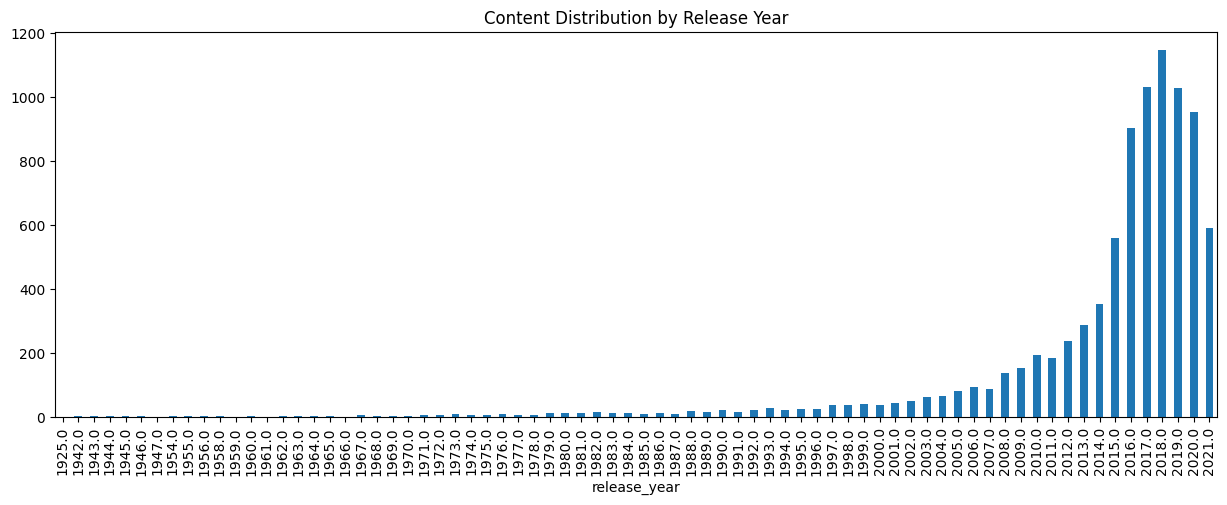

In [16]:
# Convert release year to numeric, handle errors by coercing invalid values
netflix_pandas_df['release_year'] = pd.to_numeric(netflix_pandas_df['release_year'], errors='coerce')

# Plot content distribution by release year
netflix_pandas_df['release_year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5), title='Content Distribution by Release Year')
plt.show()

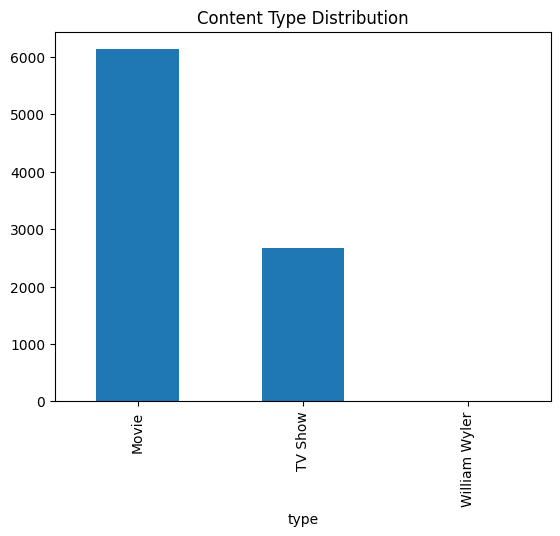

In [17]:
# Convert Spark DataFrame to Pandas DataFrame
netflix_pandas_df = netflix_data.toPandas()

# Plot distribution of content type
netflix_pandas_df['type'].value_counts().plot(kind='bar', title='Content Type Distribution')
plt.show()



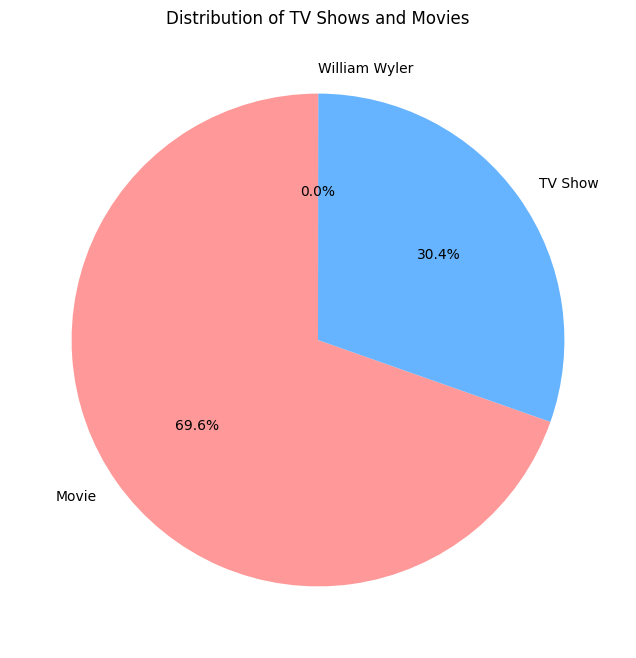

In [18]:
# Plot pie chart for content type distribution
content_type_counts = netflix_pandas_df['type'].value_counts()

# Customize colors for the pie chart
colors = ['#ff9999', '#66b3ff']

# Plot the pie chart with the new colors and percentage formatting
content_type_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), colors=colors, startangle=90)

# Set title and remove the y-axis label
plt.title('Distribution of TV Shows and Movies')
plt.ylabel('')

# Display the plot
plt.show()


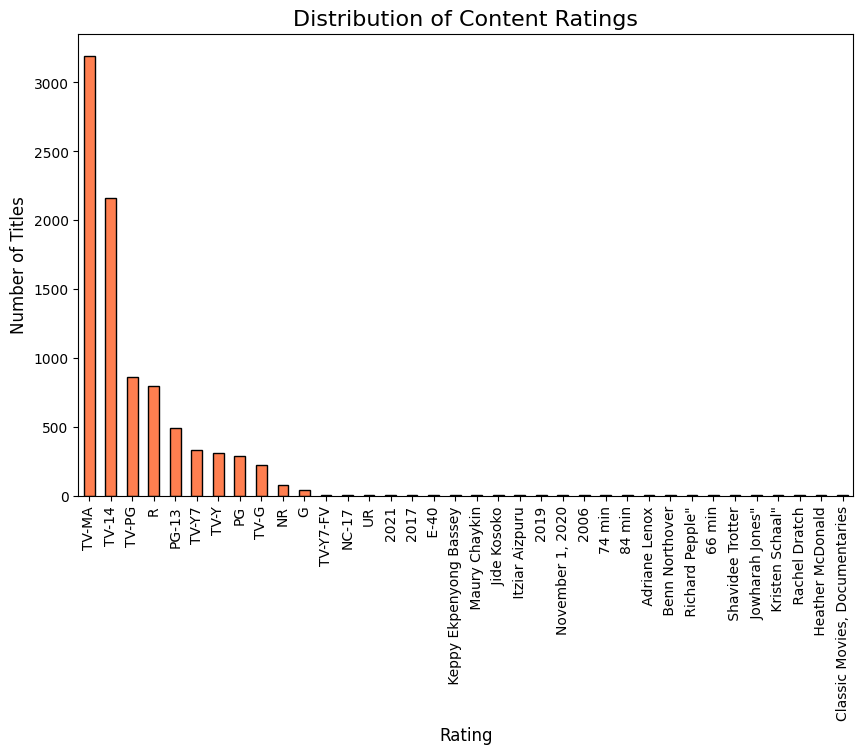

In [21]:
# Plot distribution of content ratings
rating_counts = netflix_pandas_df['rating'].value_counts()

# Plot the bar chart for rating distribution
rating_counts.plot(kind='bar', figsize=(10, 6), color='coral', edgecolor='black')

# Set title and labels
plt.title('Distribution of Content Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Titles', fontsize=12)

# Display the plot
plt.show()


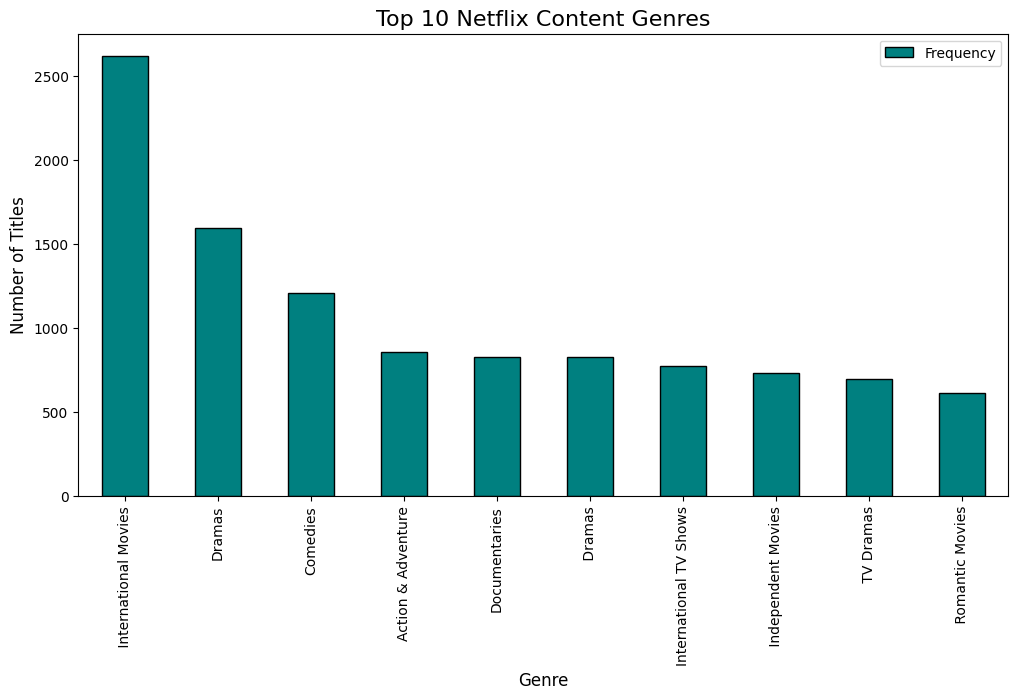

In [20]:
# Split genres and count occurrences
content_genres = netflix_pandas_df['listed_in'].dropna().str.split(',').sum()
genre_frequencies = Counter(content_genres)

# Plot top 10 most frequent genres
top_genres_df = pd.DataFrame(genre_frequencies.most_common(10), columns=['Genre', 'Frequency'])

# Customize the bar plot
top_genres_df.set_index('Genre').plot(kind='bar', figsize=(12, 6), color='teal', edgecolor='black')

# Set plot title and labels
plt.title('Top 10 Netflix Content Genres', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Titles', fontsize=12)

# Display the plot
plt.show()


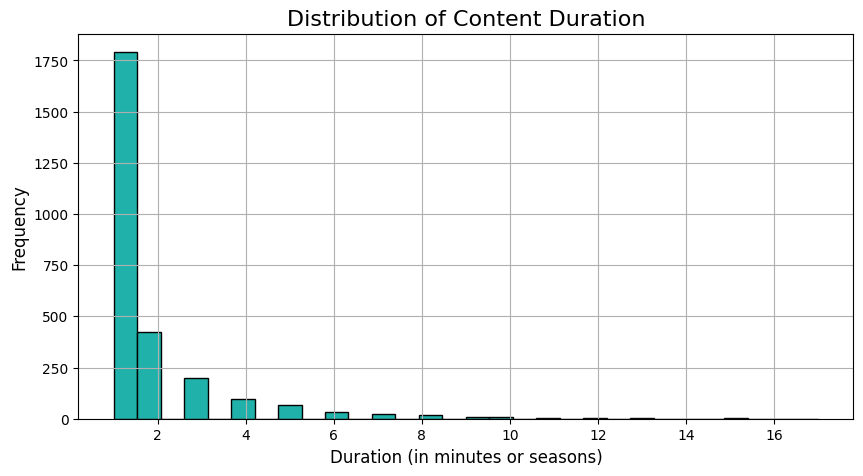

In [24]:
# Updated function to handle various duration formats
def convert_duration_to_minutes(duration):
    try:
        if 'h' in duration and 'm' in duration:  # Movies with hours and minutes
            time_parts = duration.replace('h', '').replace('m', '').split()
            hours = int(time_parts[0]) * 60  # Convert hours to minutes
            minutes = int(time_parts[1]) if len(time_parts) > 1 else 0
            return hours + minutes
        elif 'h' in duration:  # Movies in hours only
            hours = int(duration.replace('h', ''))
            return hours * 60
        elif 'm' in duration:  # Movies in minutes only
            minutes = int(duration.replace('m', ''))
            return minutes
        elif 'Season' in duration:  # TV Shows in seasons
            return int(duration.split()[0])
        else:  # Unrecognized format
            return np.nan
    except Exception as e:
        return np.nan  # Gracefully handle unexpected errors

# Apply the updated function to extract numerical duration
netflix_pandas_df['duration_minutes'] = netflix_pandas_df['duration'].apply(lambda x: convert_duration_to_minutes(x) if pd.notnull(x) else np.nan)

# Plot the distribution of content duration
netflix_pandas_df['duration_minutes'].dropna().hist(bins=30, figsize=(10, 5), color='lightseagreen', edgecolor='black')
plt.title('Distribution of Content Duration', fontsize=16)
plt.xlabel('Duration (in minutes or seasons)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()
